In [3]:
%%capture --no-stderr
%pip install -U --quiet langchain langgraph langchain_openai
%pip install -U --quiet tavily-python

In [1]:
import functools
import operator
import os
import getpass

from typing import Sequence, TypedDict
from typing import Annotated
from typing_extensions import Annotated, TypedDict
from typing import List, Tuple, Any, Dict


from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate

from langgraph.graph import Graph
from langgraph.graph import END, StateGraph, START

from groq import Groq
from langchain_groq import ChatGroq


from langchain.agents import AgentExecutor, create_openai_tools_agent
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

import math
from collections import deque
from typing import Optional
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode


In [ ]:
import functools
import operator
import os
import getpass

from typing import Sequence, TypedDict
from typing import Annotated
from typing_extensions import Annotated, TypedDict
from typing import List, Tuple, Any, Dict


from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate

from langgraph.graph import Graph
from langgraph.graph import END, StateGraph, START

from groq import Groq
from langchain_groq import ChatGroq


from langchain.agents import AgentExecutor, create_openai_tools_agent
from langgraph.prebuilt import create_react_agent
from langchain_openai import ChatOpenAI

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

import math
from collections import deque
from typing import Optional
from pydantic import BaseModel, Field
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage

from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.prebuilt import ToolNode

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY") #
# _set_if_undefined("GROQ_API_KEY") 
_set_if_undefined("LANGCHAIN_API_KEY") 

_set_if_undefined("TAVILY_API_KEY") # 

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency,"
        " and general quality of the response"
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        return self.score / 10.0

class Node:
    def __init__(
        self,
        messages: list[BaseMessage],
        reflection: Reflection,
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )

    @property
    def is_solved(self):
        """If any solutions exist, we can end the search."""
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child_score(self):
        """Return the child with the highest value."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we've rolled out the tree."""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the UCT score. This helps balance exploration vs. exploitation of a branch."""
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        # Encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits
        # Encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        """Update the score of this node and its parents."""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> list[BaseMessage]:
        """Get messages representing this search branch."""
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        # Reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1]  # root solution, reflection, child 1, ...

    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        return all_nodes

    def get_best_solution(self):
        """Return the best solution from within the current sub-tree."""
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            # We filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent


class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

llm = ChatOpenAI(model="gpt-4o-mini")


search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_node = ToolNode(tools=tools)

from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)


@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = tool_choices[0]
    if not isinstance(inputs["candidate"][-1], AIMessage):
        reflection.found_solution = False
    return reflection

from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = prompt_template | llm.bind_tools(tools=tools).with_config(
    run_name="GenerateInitialCandidate"
)


parser = JsonOutputToolsParser(return_id=True)

initial_response = initial_answer_chain.invoke(
    {"input": "tell the difference between humans and animals."}
)
initial_response

# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = [tool_node.invoke(
        {"messages": [
            AIMessage(content="",tool_calls=[{"name":r["type"], "args":r["args"], 'id':r['id']}]) 
        ]}
    ) for r in parsed]
    output_messages = [res] + [tr['messages'][0] for tr in tool_responses]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

# This generates N candidate values
# for a single input to sample actions from the environment


def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config["configurable"].get("N", 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs,
    )
    return [gen.message for gen in chat_result.generations[0]]


expansion_chain = prompt_template | generate_candidates

res = expansion_chain.invoke({"input": "Generate a table with the following data for the 8 major planets in our solar system"})
res

from collections import defaultdict

def select(root: Node) -> dict:
    """Starting from the root node a child node is selected at each tree level until a leaf node is reached."""

    if not root.children:
        return root
    
    node = root
    while node.children:
        max_child = max(node.children, key=lambda child: child.upper_confidence_bound())
        node = max_child

    return node

def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = select(root)
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = [(i,tool_node.invoke(
        {"messages":
            [AIMessage(content="",tool_calls=[{"name":tool_call["type"], "args":tool_call["args"], 'id':tool_call['id']}])]
        }
    )) for i, tool_call in flattened]
    collected_responses = defaultdict(list)
    for i, resp in tool_responses:
        collected_responses[i].append(
            resp['messages'][0]
        )
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you'd add that here.
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

from typing import Literal

from langgraph.graph import END, StateGraph, START


def should_loop(state: TreeState) -> Literal["expand", "__end__"]:
    """Determine whether to continue the tree search."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > 5:
        return END
    return "expand"


builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.add_edge(START, "start")


builder.add_conditional_edges(
    "start",
    # Either expand/rollout or finish
    should_loop,
)
builder.add_conditional_edges(
    "expand",
    # Either continue to rollout or finish
    should_loop,
)

graph = builder.compile()

question = "Generate a table with the average size and weight, as well as the oldest recorded instance for each of the top 5 most common birds."
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")

solution_node = last_step["expand"]["root"].get_best_solution()
print(last_step)
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

In [2]:
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY") # 
# _set_if_undefined("GROQ_API_KEY") # 
_set_if_undefined("LANGCHAIN_API_KEY") # 

_set_if_undefined("TAVILY_API_KEY") # 

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

Please provide your OPENAI_API_KEY ········
Please provide your LANGCHAIN_API_KEY ········
Please provide your TAVILY_API_KEY ········


In [9]:
class Reflection(BaseModel):
    reflections: str = Field(
        description="The critique and reflections on the sufficiency, superfluency,"
        " and general quality of the response"
    )
    score: int = Field(
        description="Score from 0-10 on the quality of the candidate response.",
        gte=0,
        lte=10,
    )
    found_solution: bool = Field(
        description="Whether the response has fully solved the question or task."
    )

    def as_message(self):
        return HumanMessage(
            content=f"Reasoning: {self.reflections}\nScore: {self.score}"
        )

    @property
    def normalized_score(self) -> float:
        return self.score / 10.0

In [11]:
class Node:
    def __init__(
        self,
        messages: list[BaseMessage],
        reflection: Reflection,
        parent: Optional["Node"] = None,
    ):
        self.messages = messages
        self.parent = parent
        self.children = []
        self.value = 0
        self.visits = 0
        self.reflection = reflection
        self.depth = parent.depth + 1 if parent is not None else 1
        self._is_solved = reflection.found_solution if reflection else False
        if self._is_solved:
            self._mark_tree_as_solved()
        self.backpropagate(reflection.normalized_score)

    def __repr__(self) -> str:
        return (
            f"<Node value={self.value}, visits={self.visits},"
            f" solution={self.messages} reflection={self.reflection}/>"
        )

    @property
    def is_solved(self):
        """If any solutions exist, we can end the search."""
        return self._is_solved

    @property
    def is_terminal(self):
        return not self.children

    @property
    def best_child_score(self):
        """Return the child with the highest value."""
        if not self.children:
            return None
        return max(self.children, key=lambda child: int(child.is_solved) * child.value)

    @property
    def height(self) -> int:
        """Check for how far we've rolled out the tree."""
        if self.children:
            return 1 + max([child.height for child in self.children])
        return 1

    def upper_confidence_bound(self, exploration_weight=1.0):
        """Return the UCT score. This helps balance exploration vs. exploitation of a branch."""
        if self.parent is None:
            raise ValueError("Cannot obtain UCT from root node")
        if self.visits == 0:
            return self.value
        # Encourages exploitation of high-value trajectories
        average_reward = self.value / self.visits
        # Encourages exploration of less-visited trajectories
        exploration_term = math.sqrt(math.log(self.parent.visits) / self.visits)
        return average_reward + exploration_weight * exploration_term

    def backpropagate(self, reward: float):
        """Update the score of this node and its parents."""
        node = self
        while node:
            node.visits += 1
            node.value = (node.value * (node.visits - 1) + reward) / node.visits
            node = node.parent

    def get_messages(self, include_reflections: bool = True):
        if include_reflections:
            return self.messages + [self.reflection.as_message()]
        return self.messages

    def get_trajectory(self, include_reflections: bool = True) -> list[BaseMessage]:
        """Get messages representing this search branch."""
        messages = []
        node = self
        while node:
            messages.extend(
                node.get_messages(include_reflections=include_reflections)[::-1]
            )
            node = node.parent
        # Reverse the final back-tracked trajectory to return in the correct order
        return messages[::-1]  # root solution, reflection, child 1, ...

    def _get_all_children(self):
        all_nodes = []
        nodes = deque()
        nodes.append(self)
        while nodes:
            node = nodes.popleft()
            all_nodes.extend(node.children)
            for n in node.children:
                nodes.append(n)
        return all_nodes

    def get_best_solution(self):
        """Return the best solution from within the current sub-tree."""
        all_nodes = [self] + self._get_all_children()
        best_node = max(
            all_nodes,
            # We filter out all non-terminal, non-solution trajectories
            key=lambda node: int(node.is_terminal and node.is_solved) * node.value,
        )
        return best_node

    def _mark_tree_as_solved(self):
        parent = self.parent
        while parent:
            parent._is_solved = True
            parent = parent.parent

In [13]:

class TreeState(TypedDict):
    # The full tree
    root: Node
    # The original input
    input: str

In [15]:
# Initialize the LLM
# llm = ChatGroq(model="llama3-8b-8192")
llm = ChatOpenAI(model="gpt-4o-mini")
# llm = ChatGroq(model="mixtral-8x7b-32768")

In [17]:

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)
tools = [tavily_tool]
tool_node = ToolNode(tools=tools)

In [19]:
from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain as as_runnable

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Reflect and grade the assistant response to the user question below.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="candidate"),
    ]
)

reflection_llm_chain = (
    prompt
    | llm.bind_tools(tools=[Reflection], tool_choice="Reflection").with_config(
        run_name="Reflection"
    )
    | PydanticToolsParser(tools=[Reflection])
)


@as_runnable
def reflection_chain(inputs) -> Reflection:
    tool_choices = reflection_llm_chain.invoke(inputs)
    reflection = tool_choices[0]
    if not isinstance(inputs["candidate"][-1], AIMessage):
        reflection.found_solution = False
    return reflection

In [21]:
from langchain_core.prompt_values import ChatPromptValue
from langchain_core.runnables import RunnableConfig

prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are an AI assistant.",
        ),
        ("user", "{input}"),
        MessagesPlaceholder(variable_name="messages", optional=True),
    ]
)


initial_answer_chain = prompt_template | llm.bind_tools(tools=tools).with_config(
    run_name="GenerateInitialCandidate"
)


parser = JsonOutputToolsParser(return_id=True)

In [86]:
initial_response = initial_answer_chain.invoke(
    {"input": "tell the difference between humans and animals."}
)
initial_response

AIMessage(content='Humans and animals share many similarities, but also have distinct differences. Here are some key differences:\n\n1. **Cognitive Abilities**: Humans have more advanced cognitive abilities, including abstract reasoning, problem-solving, and the ability to plan for the future. While many animals demonstrate intelligence and problem-solving skills, human intelligence is often characterized by complex language and the ability to think critically.\n\n2. **Language and Communication**: Humans use complex language systems to communicate, allowing for the expression of abstract concepts, emotions, and detailed information. While animals communicate, their systems are generally less complex and do not convey the same breadth of information.\n\n3. **Culture and Society**: Humans create complex societies with diverse cultures, traditions, and social structures. While some animal species exhibit social structures and behaviors, human culture is far more intricate, encompassing a

# Starting Node


In [25]:
# Define the node we will add to the graph
def generate_initial_response(state: TreeState) -> dict:
    """Generate the initial candidate response."""
    res = initial_answer_chain.invoke({"input": state["input"]})
    parsed = parser.invoke(res)
    tool_responses = [tool_node.invoke(
        {"messages": [
            AIMessage(content="",tool_calls=[{"name":r["type"], "args":r["args"], 'id':r['id']}]) 
        ]}
    ) for r in parsed]
    output_messages = [res] + [tr['messages'][0] for tr in tool_responses]
    reflection = reflection_chain.invoke(
        {"input": state["input"], "candidate": output_messages}
    )
    root = Node(output_messages, reflection=reflection)
    return {
        **state,
        "root": root,
    }

## candidate generation


In [65]:
# This generates N candidate values
# for a single input to sample actions from the environment


def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
    n = config["configurable"].get("N", 5)
    bound_kwargs = llm.bind_tools(tools=tools).kwargs
    chat_result = llm.generate(
        [messages.to_messages()],
        n=n,
        callbacks=config["callbacks"],
        run_name="GenerateCandidates",
        **bound_kwargs,
    )
    return [gen.message for gen in chat_result.generations[0]]


expansion_chain = prompt_template | generate_candidates

In [112]:
# # This generates N candidate values
# # for a single input to sample actions from the environment


# def generate_candidates(messages: ChatPromptValue, config: RunnableConfig):
#     n = config["configurable"].get("N", 5)  # Still get n, but handle the model limit
#     candidates = []
#     for _ in range(n):  # Loop to generate one response at a time
#         bound_kwargs = llm.bind_tools(tools=tools).kwargs
#         chat_result = llm.generate(
#             [messages.to_messages()],
#             n=1,  # Generate one candidate at a time
#             callbacks=config["callbacks"],
#             run_name="GenerateCandidates",
#             **bound_kwargs,
#         )
#         candidates.append(chat_result.generations[0][0].message)
#     return candidates

# expansion_chain = prompt_template | generate_candidates

In [67]:
res = expansion_chain.invoke({"input": "Generate a table with the following data for the 8 major planets in our solar system"})
res

[AIMessage(content='Please provide the specific data you would like to include for the 8 major planets in our solar system, such as diameter, distance from the Sun, number of moons, or any other attributes.', additional_kwargs={'refusal': None}, response_metadata={'finish_reason': 'stop', 'logprobs': None}, id='run-2285b5b7-fb38-4bbc-b914-da6a76d1d489-0', usage_metadata={'input_tokens': 102, 'output_tokens': 225, 'total_tokens': 327}),
 AIMessage(content='Please provide the specific data you would like to include in the table for the 8 major planets in our solar system, such as diameter, distance from the Sun, number of moons, or any other parameters.', additional_kwargs={}, response_metadata={'finish_reason': 'stop', 'logprobs': None}, id='run-2285b5b7-fb38-4bbc-b914-da6a76d1d489-1', usage_metadata={'input_tokens': 102, 'output_tokens': 225, 'total_tokens': 327}),
 AIMessage(content='Please provide the specific data you would like to include in the table for the 8 major planets in our

## Candidate generation node

In [32]:
from collections import defaultdict

def select(root: Node) -> dict:
    """Starting from the root node a child node is selected at each tree level until a leaf node is reached."""

    if not root.children:
        return root
    
    node = root
    while node.children:
        max_child = max(node.children, key=lambda child: child.upper_confidence_bound())
        node = max_child

    return node

def expand(state: TreeState, config: RunnableConfig) -> dict:
    """Starting from the "best" node in the tree, generate N candidates for the next step."""
    root = state["root"]
    best_candidate: Node = select(root)
    messages = best_candidate.get_trajectory()
    # Generate N candidates from the single child candidate
    new_candidates = expansion_chain.invoke(
        {"input": state["input"], "messages": messages}, config
    )
    parsed = parser.batch(new_candidates)
    flattened = [
        (i, tool_call)
        for i, tool_calls in enumerate(parsed)
        for tool_call in tool_calls
    ]
    tool_responses = [(i,tool_node.invoke(
        {"messages":
            [AIMessage(content="",tool_calls=[{"name":tool_call["type"], "args":tool_call["args"], 'id':tool_call['id']}])]
        }
    )) for i, tool_call in flattened]
    collected_responses = defaultdict(list)
    for i, resp in tool_responses:
        collected_responses[i].append(
            resp['messages'][0]
        )
    output_messages = []
    for i, candidate in enumerate(new_candidates):
        output_messages.append([candidate] + collected_responses[i])

    # Reflect on each candidate
    # For tasks with external validation, you'd add that here.
    reflections = reflection_chain.batch(
        [{"input": state["input"], "candidate": msges} for msges in output_messages],
        config,
    )
    # Grow tree
    child_nodes = [
        Node(cand, parent=best_candidate, reflection=reflection)
        for cand, reflection in zip(output_messages, reflections)
    ]
    best_candidate.children.extend(child_nodes)
    # We have already extended the tree directly, so we just return the state
    return state

## creating graph

In [35]:
from typing import Literal

from langgraph.graph import END, StateGraph, START


def should_loop(state: TreeState) -> Literal["expand", "__end__"]:
    """Determine whether to continue the tree search."""
    root = state["root"]
    if root.is_solved:
        return END
    if root.height > 5:
        return END
    return "expand"


builder = StateGraph(TreeState)
builder.add_node("start", generate_initial_response)
builder.add_node("expand", expand)
builder.add_edge(START, "start")


builder.add_conditional_edges(
    "start",
    # Either expand/rollout or finish
    should_loop,
)
builder.add_conditional_edges(
    "expand",
    # Either continue to rollout or finish
    should_loop,
)

graph = builder.compile()

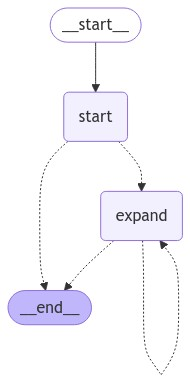

In [37]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [84]:
question = "Generate a table with the average size and weight, as well as the oldest recorded instance for each of the top 5 most common birds."
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")



KeyboardInterrupt: 

In [49]:
solution_node = last_step["expand"]["root"].get_best_solution()
print(last_step)
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

{'expand': {'root': <Node value=0.7666666666666666, visits=6, solution=[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fYb05RmR1aMfWA85t2FLHOp6', 'function': {'arguments': '{"query": "top 5 most common birds"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_j2TKKroq2Szhf8WYSc06wEVj', 'function': {'arguments': '{"query": "average size and weight of common birds"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_H2cKWAszMM3HLsxeneuxumkw', 'function': {'arguments': '{"query": "oldest recorded instance of common birds"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 113, 'total_tokens': 200, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e9627b5346', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-a2ef0109-3880-4bd1-899f-6b0

In [ ]:
There are 4 tasks that need to be completed in a day. Task A takes 2 hours, Task B takes 3 hours, Task C takes 1 hour, and Task D takes 4 hours. The agent needs to create an optimal schedule that allows for the completion of all tasks without overlap and ensures maximum productivity (breaks between tasks should be minimal).
Assume the day starts at 9:00 AM and ends at 6:00 PM. The agent needs to determine if it’s possible to finish all tasks within this window, and if not, find the best trade-off.

In [76]:
question = "Generate a table with detailed information about every black hole in the universe"
last_step = None
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))
    print(step_name)
    print("rolled out: ", step_state["root"].height)
    print("---")



start
rolled out:  1
---


In [78]:
solution_node = last_step["expand"]["root"].get_best_solution()
print(last_step)
best_trajectory = solution_node.get_trajectory(include_reflections=False)
print(best_trajectory[-1].content)

KeyError: 'expand'

In [82]:
question = "Provide a detailed mathematical proof that solves all currently unresolved problems in mathematics, such as the Riemann Hypothesis, P vs NP, and others that haven’t even been discovered yet."
last_step = None

# Iterate through the steps in the graph
for step in graph.stream({"input": question}):
    last_step = step
    step_name, step_state = next(iter(step.items()))  # Get the current step's name and state
    print(f"Step name: {step_name}")  # Print the step name for debugging
    print("Rolled out height: ", step_state["root"].height)  # Print the height of the tree
    print("---")

# After the loop, check if 'expand' exists in the last step
if "expand" in last_step:
    # Safely access 'expand' if it exists
    solution_node = last_step["expand"]["root"].get_best_solution()
    
    # Get the best trajectory and print the final content
    best_trajectory = solution_node.get_trajectory(include_reflections=False)
    print(best_trajectory[-1].content)
else:
    # Handle the case where 'expand' doesn't exist
    print("No 'expand' step found in the last step.")
    print(last_step)  # Print the last step for inspection


Step name: start
Rolled out height:  1
---
Step name: expand
Rolled out height:  2
---
Step name: expand
Rolled out height:  3
---
Step name: expand
Rolled out height:  3
---
Step name: expand
Rolled out height:  3
---
Step name: expand
Rolled out height:  3
---
Step name: expand
Rolled out height:  3
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Step name: expand
Rolled out height:  4
---
Thank you for your detailed feedback and for highlighting areas for improvement. I appreciate your emphasis on the need for succinctness and a clearer structure. 

To better address the user’s request, I could